# Data Project

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import clear_output

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [2]:
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


In [3]:
ind = DstApi('STRAFNA3')

In [4]:
tabsum = ind.tablesummary(language='en')
display(tabsum)

Table STRAFNA3: Persons guilty in crimes by sex, age, country of origin and time
Last update: 2023-12-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KOEN,2,M,Men,K,Women,False
1,ALDER,4,TOT,"Age, total",50-79,50-79 years,False
2,IELAND,75,0000,Total,7300,"Other countries, non-western",False
3,Tid,21,2000,2000,2022,2022,True


In [5]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')
params

{'table': 'strafna3',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOEN', 'values': ['*']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'IELAND', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [6]:
variables = params['variables'] 
variables[1]['values'] = ['TOT']
variables[3]['values'] = ['2017', '2018', '2019', '2020', '2021', '2022']
params

{'table': 'strafna3',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOEN', 'values': ['*']},
  {'code': 'ALDER', 'values': ['TOT']},
  {'code': 'IELAND', 'values': ['*']},
  {'code': 'Tid', 'values': ['2017', '2018', '2019', '2020', '2021', '2022']}]}

In [7]:
inc_api = ind.get_data(params=params)
inc_api.head(900)

,KOEN,ALDER,IELAND,TID,INDHOLD
0,Women,"Age, total",Yugoslavia,2020,297
1,Women,"Age, total",Poland,2020,507
2,Women,"Age, total",Portugal,2020,17
3,Women,"Age, total",Romania,2020,302
4,Women,"Age, total",Switzerland,2020,14
...,...,...,...,...,...
895,Men,"Age, total",Republic of North Macedonia,2018,200
896,Men,"Age, total","Yugoslavia, Federal Republic",2018,68
897,Men,"Age, total","Other countries, total",2018,1340
898,Men,"Age, total","Other countries, western",2018,88


In [8]:
# Assuming you have already loaded and prepared the DataFrame inc_api

# Get the unique values from the 'IELAND' column
represented_countries = inc_api['IELAND'].unique()

# Display the list of represented countries
print("Represented Countries:")
for country in represented_countries:
    print(country)


Represented Countries:
Yugoslavia
Poland
Portugal
Romania
Switzerland
Soviet Union
Spain
United Kingdom
Turkey
Hungary
Germany
Austria
Algeria
Ethiopia
Ghana
Kenya
Morocco
Nigeria
South Africa
Tanzania
Tunisia
Uganda
Egypt
Somalia
Argentina
Brazil
Canada
Chile
USA
Afghanistan
Myanmar
Sri Lanka
India
Indonesia
Iraq
Iran
Israel
Japan
Jordan
China
Kuwait
Lebanon
Vietnam
Pakistan
Philippines
Syria
Thailand
Australia
Estonia
Latvia
Lithuania
Russia
Ukraine
Croatia
Bosnia and Herzegovina
Republic of North Macedonia
Yugoslavia, Federal Republic
Other countries, total
Other countries, western
Other countries, non-western
Total
Denmark
Finland
Iceland
Norway
Sweden
Belgium
Bulgaria
Czechoslovakia
France
Greece
Netherlands
Ireland
Italy
Serbia and Montenegro


Dropdown(description='Gender:', options=('Men', 'Women'), value='Men')

IntSlider(value=2017, description='Year', max=2022, min=2017)

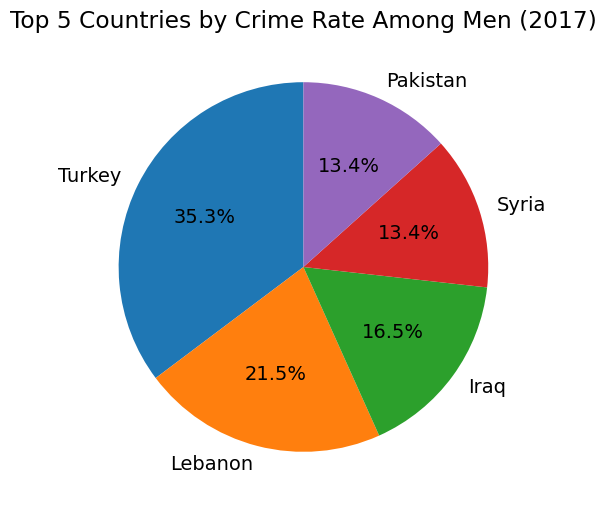

In [9]:
# Your DataFrame loading and preparation code here

def plot_pie_chart(gender, selected_year):
    # Ensure you use the correct DataFrame name and column names
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & 
                            (inc_api['IELAND'] != 'Total') & 
                            (inc_api['IELAND'] != 'Denmark') & 
                            (inc_api['IELAND'] != 'Other countries, non-western') & 
                            (inc_api['IELAND'] != 'Other countries, total') & 
                            (inc_api['TID'].astype(int) == selected_year)]
    top_countries = filtered_data.groupby('IELAND')['INDHOLD'].sum().nlargest(5)
    
    plt.figure(figsize=(10, 6))
    top_countries.plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='', 
                       title=f'Top 5 Countries by Crime Rate Among {gender} ({selected_year})')
    plt.show()

def on_gender_year_selected(change):
    clear_output(wait=True)
    display(gender_dropdown)  # Redisplay the dropdown to ensure it persists after clearing the output
    display(year_slider)  # Display the year slider
    plot_pie_chart(gender_dropdown.value, year_slider.value)

gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:')
year_slider = widgets.IntSlider(description='Year', min=2017, max=2022, value=2017)

gender_dropdown.observe(on_gender_year_selected, names='value')
year_slider.observe(on_gender_year_selected, names='value')

display(gender_dropdown)
display(year_slider)

plot_pie_chart('Men', 2017)  # Default display


Dropdown(description='Gender:', options=('Men', 'Women'), value='Men')

<Figure size 1000x600 with 0 Axes>

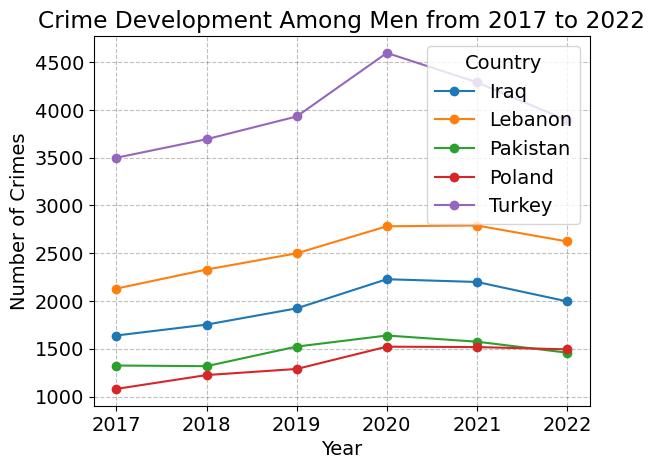

In [10]:
def plot_crime_development(gender):
    # Step 1: Filter by gender and year
    filtered_data = inc_api[(inc_api['KOEN'] == gender) & (inc_api['TID'].between(2017, 2022))]
    
    # Step 2: Further filter to include only the specified countries
    countries = ["Turkey", "Pakistan", "Iraq", "Poland", "Lebanon"]
    filtered_data = filtered_data[filtered_data['IELAND'].isin(countries)]
    
    # Step 3: Group by country and year, then sum
    grouped_data = filtered_data.groupby(['IELAND', 'TID'])['INDHOLD'].sum().unstack()
    
    # Step 4: Plot the data
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
    grouped_data.T.plot(kind='line', marker='o')  # Transpose to have years on the x-axis and countries as lines
    plt.title(f'Crime Development Among {gender} from 2017 to 2022')
    plt.xlabel('Year')
    plt.ylabel('Number of Crimes')
    plt.grid(True)
    plt.legend(title='Country')
    plt.show()

def on_gender_selected(change):
    clear_output(wait=True)
    display(gender_dropdown)  # Redisplay the dropdown to ensure it persists after clearing the output
    plot_crime_development(change['new'])

gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:')
gender_dropdown.observe(on_gender_selected, names='value')

display(gender_dropdown)
plot_crime_development('Men')  # Default display


In [11]:
indvan = DstApi('INDVAN')

tabsum = indvan.tablesummary(language='en')
display(tabsum)

Table INDVAN: Immigration by sex, age, citizenship, country of last residence and time
Last update: 2024-02-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KØN,2,M,Men,K,Women,False
1,ALDER,126,0,0 years,125,125 years,False
2,STATSB,2,DANSK,Denmark,UDLAND,Foreign,False
3,INDVLAND,242,5901,Faroe Islands,5999,Not stated,False
4,Tid,44,1980,1980,2023,2023,True


In [12]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = indvan._define_base_params(language='en')
params

{'table': 'indvan',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KØN', 'values': ['*']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'STATSB', 'values': ['*']},
  {'code': 'INDVLAND', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [13]:
indvan_api = indvan.get_data(params=params)

In [15]:
indvan_api.head(100)

,KØN,ALDER,STATSB,INDVLAND,TID,INDHOLD
0,Men,9 years,Denmark,Mexico,1995,1
1,Men,9 years,Denmark,Philippines,1995,1
2,Men,21 years,Denmark,Taiwan,1995,1
3,Men,21 years,Denmark,New Zealand,1995,1
4,Men,30 years,Denmark,Thailand,1995,1
...,...,...,...,...,...,...
95,Men,2 years,Denmark,Ukraine,1995,1
96,Men,2 years,Denmark,Egypt,1995,1
97,Men,2 years,Denmark,Ethiopia,1995,1
98,Men,2 years,Denmark,Guinea-Bissau,1995,1


Dropdown(description='Gender:', options=('Men', 'Women'), value='Men')

IntSlider(value=2017, description='Year', max=2022, min=2017)

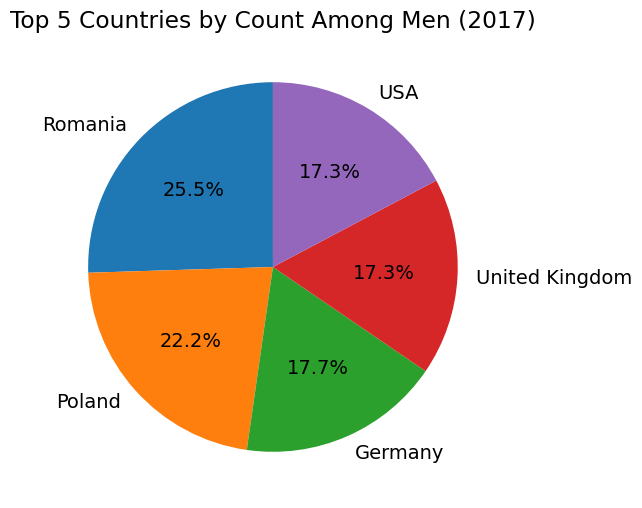

In [16]:

def plot_pie_chart(gender, selected_year):
    # Filter the data based on the selected gender and the selected year
    filtered_data = indvan_api[(indvan_api['KØN'] == gender) & 
                                       (indvan_api['TID'] == selected_year)]
    
    # Aggregate the counts by country
    top_countries = filtered_data.groupby('INDVLAND')['INDHOLD'].sum().nlargest(5)
    
    plt.figure(figsize=(10, 6))
    top_countries.plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='', 
                       title=f'Top 5 Countries by Count Among {gender} ({selected_year})')
    plt.show()

def on_gender_year_selected(change):
    clear_output(wait=True)
    display(gender_dropdown)  # Redisplay the dropdown to ensure it persists after clearing the output
    display(year_slider)  # Display the year slider
    plot_pie_chart(gender_dropdown.value, year_slider.value)

gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:')
year_slider = widgets.IntSlider(description='Year', min=2017, max=2022, value=2017)


gender_dropdown.observe(on_gender_year_selected, names='value')
year_slider.observe(on_gender_year_selected, names='value')

display(gender_dropdown)
display(year_slider)

plot_pie_chart('Men', 2017)  # Default display


Dropdown(description='Gender:', options=('Men', 'Women'), value='Men')

<Figure size 1000x600 with 0 Axes>

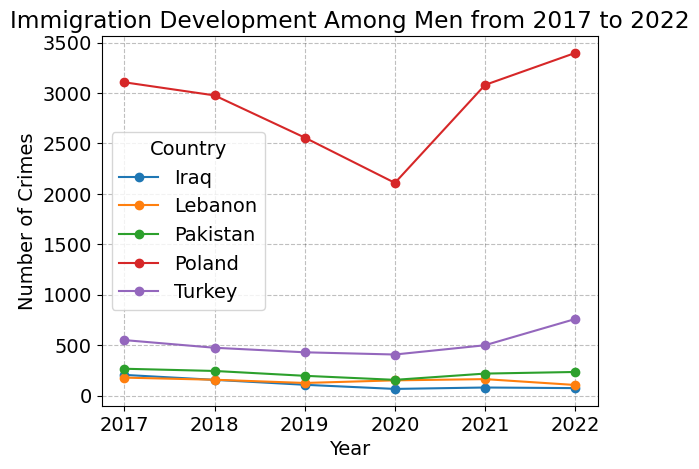

In [17]:
def plot_crime_development(gender):
    # Step 1: Filter by gender and year
    filtered_data = indvan_api[(indvan_api['KØN'] == gender) & (indvan_api['TID'].between(2017, 2022))]
    
    # Step 2: Further filter to include only the specified countries
    countries = ["Turkey", "Pakistan", "Iraq", "Poland", "Lebanon"]
    filtered_data = filtered_data[filtered_data['INDVLAND'].isin(countries)]
    
    # Step 3: Group by country and year, then sum
    grouped_data = filtered_data.groupby(['INDVLAND', 'TID'])['INDHOLD'].sum().unstack()
    
    # Step 4: Plot the data
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
    grouped_data.T.plot(kind='line', marker='o')  # Transpose to have years on the x-axis and countries as lines
    plt.title(f'Immigration Development Among {gender} from 2017 to 2022')
    plt.xlabel('Year')
    plt.ylabel('Number of Crimes')
    plt.grid(True)
    plt.legend(title='Country')
    plt.show()

def on_gender_selected(change):
    clear_output(wait=True)
    display(gender_dropdown)  # Redisplay the dropdown to ensure it persists after clearing the output
    plot_crime_development(change['new'])

gender_dropdown = widgets.Dropdown(options=['Men', 'Women'], description='Gender:')
gender_dropdown.observe(on_gender_selected, names='value')

display(gender_dropdown)
plot_crime_development('Men')  # Default display
